# DeepFont Models Visualized

This notebook provides visualizations of the DeepFont model architectures, including both the autoencoder (DeepFontAE) and the classifier (DeepFont). The visualizations help in understanding the structure and flow of data through the models.

In the original paper, the exact architectures were not explicitly detailed and needed to be inferred from the text and figures provided. This notebook aims to clarify those architectures through visual representation.

## Overview

We will visualize two models:
1. **DeepFontAE**: The autoencoder used for unsupervised pretraining
2. **DeepFont**: The full classification model (which can use pretrained encoder weights)

Both models will be visualized to show:
- Layer types and dimensions
- Input/output shapes at each stage
- Parameter counts
- Overall architecture flow

## Step 1: Setup and Dependencies

Install and import necessary libraries for visualization:
- `torchinfo` or `torchsummary` for model summaries
- `graphviz` and `torchviz` for computational graph visualization (optional)
- Standard PyTorch utilities

In [1]:
import torch
from torchinfo import summary
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
import numpy as np
from deepfont.models.deepfont import DeepFontAE, DeepFont

# Create assets directory
assets_dir = Path("../assets")
assets_dir.mkdir(exist_ok=True)

## Step 2: Instantiate Models

Create instances of both models:
- `DeepFontAE`: Autoencoder with optional output activation
- `DeepFont`: Classifier with specified number of output classes

We'll use a representative number of classes (e.g., 2383 fonts from the paper) for visualization.

In [2]:
# Instantiate the autoencoder
ae_model = DeepFontAE(output_activation="sigmoid")

# Instantiate the classifier with 2383 classes (from the paper)
classifier_model = DeepFont(num_out=2383)

## Step 3: DeepFontAE Architecture Visualization

Visualize the autoencoder architecture:

### 3.1 Model Summary
Display a detailed summary showing:
- Layer names and types
- Output shapes at each layer
- Number of parameters (trainable and total)
- Model input size (105×105 grayscale images)

### 3.2 Encoder-Decoder Structure
Show the encoder and decoder separately:
- **Encoder**: Conv layers with max pooling for compression
- **Decoder**: Transposed convolutions and upsampling for reconstruction

### 3.3 Information Flow
Illustrate how the spatial dimensions change through the network:
- Input: (batch_size, 1, 105, 105)
- Latent representation shape
- Output: (batch_size, 1, 105, 105) - reconstructed image

In [3]:
# Display comprehensive model summary
print("=" * 80)
print("DeepFontAE - Complete Architecture")
print("=" * 80)
ae_summary = summary(
    ae_model,
    input_size=(1, 1, 105, 105),
    col_names=["input_size", "output_size", "num_params", "kernel_size"],
    depth=5,
    verbose=0,
)
print(ae_summary)

DeepFontAE - Complete Architecture
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
DeepFontAE                               [1, 1, 105, 105]          [1, 1, 105, 105]          --                        --
├─Sequential: 1-1                        [1, 1, 105, 105]          [1, 128, 12, 12]          --                        --
│    └─Conv2d: 2-1                       [1, 1, 105, 105]          [1, 64, 48, 48]           7,808                     [11, 11]
│    └─MaxPool2d: 2-2                    [1, 64, 48, 48]           [1, 64, 24, 24]           --                        2
│    └─ReLU: 2-3                         [1, 64, 24, 24]           [1, 64, 24, 24]           --                        --
│    └─Conv2d: 2-4                       [1, 64, 24, 24]           [1, 128, 24, 24]          204,928                   [5, 5]
│    └─MaxPool2d: 2-5                    [1, 128, 24, 24]          [1, 128, 12, 12]         

In [4]:
# Visualize encoder and decoder separately
print("\n" + "=" * 80)
print("DeepFontAE - Encoder")
print("=" * 80)
encoder_summary = summary(
    ae_model.encoder,
    input_size=(1, 1, 105, 105),
    col_names=["input_size", "output_size", "num_params"],
    depth=5,
    verbose=0,
)
print(encoder_summary)

print("\n" + "=" * 80)
print("DeepFontAE - Decoder")
print("=" * 80)
# Get encoder output shape to use as decoder input
device = next(ae_model.parameters()).device
with torch.no_grad():
    encoder_out = ae_model.encoder(torch.randn(1, 1, 105, 105, device=device))
    decoder_input_shape = encoder_out.shape

decoder_summary = summary(
    ae_model.decoder,
    input_size=decoder_input_shape,
    col_names=["input_size", "output_size", "num_params"],
    depth=5,
    verbose=0,
)
print(decoder_summary)


DeepFontAE - Encoder
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [1, 1, 105, 105]          [1, 128, 12, 12]          --
├─Conv2d: 1-1                            [1, 1, 105, 105]          [1, 64, 48, 48]           7,808
├─MaxPool2d: 1-2                         [1, 64, 48, 48]           [1, 64, 24, 24]           --
├─ReLU: 1-3                              [1, 64, 24, 24]           [1, 64, 24, 24]           --
├─Conv2d: 1-4                            [1, 64, 24, 24]           [1, 128, 24, 24]          204,928
├─MaxPool2d: 1-5                         [1, 128, 24, 24]          [1, 128, 12, 12]          --
├─ReLU: 1-6                              [1, 128, 12, 12]          [1, 128, 12, 12]          --
Total params: 212,736
Trainable params: 212,736
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 136.03
Input size (MB): 0.04
Forward/backward pass size (MB): 1.77
Params size (MB): 0.85


Saved visualization to: ../assets/deepfontae_architecture.png


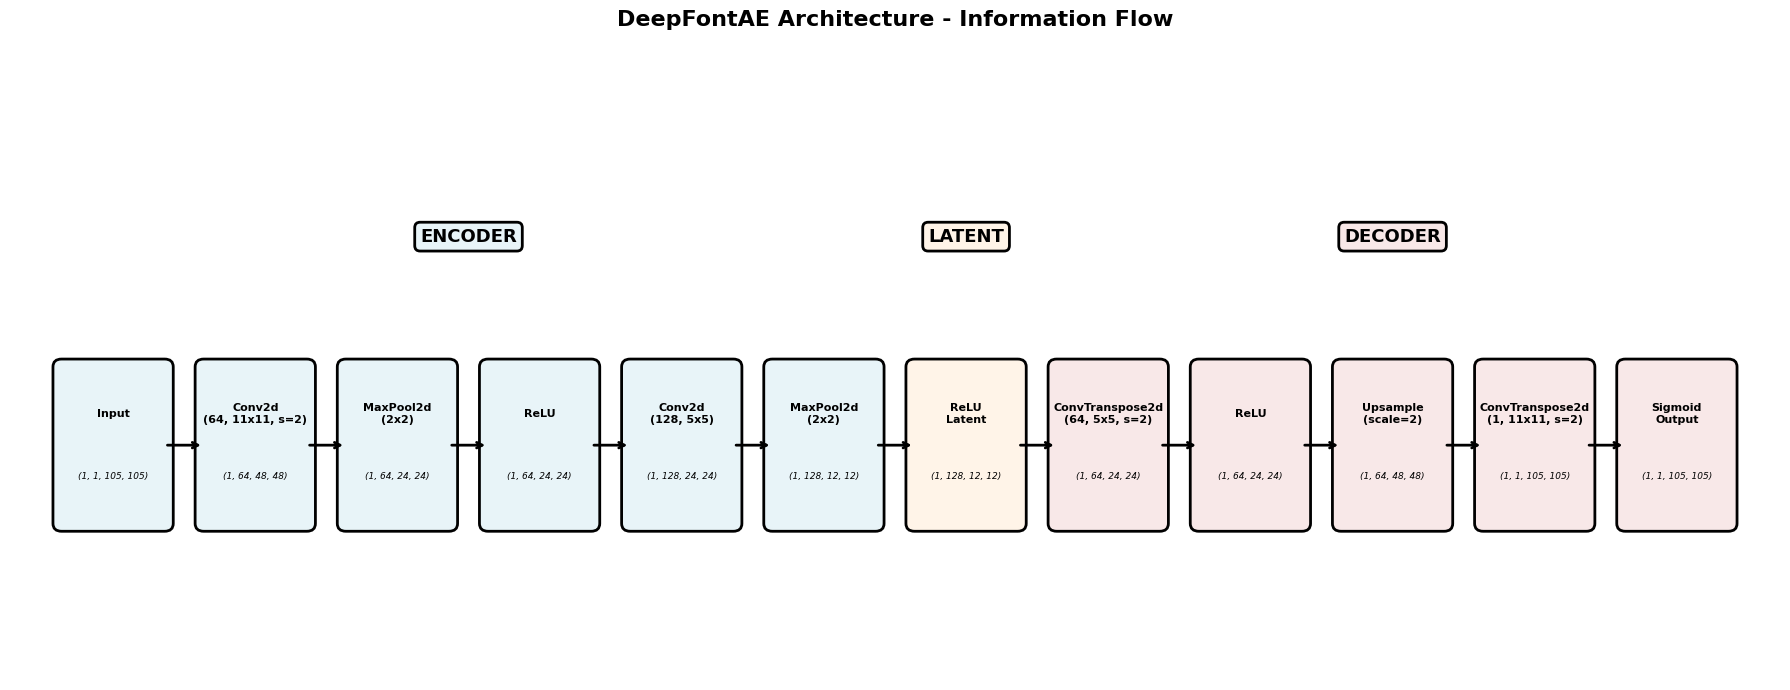

In [5]:
# Create visual diagram of information flow through DeepFontAE
fig, ax = plt.subplots(figsize=(18, 7))
ax.axis("off")

# Define layer information with uniform spacing
layer_names = [
    ("Input", "(1, 1, 105, 105)"),
    ("Conv2d\n(64, 11x11, s=2)", "(1, 64, 48, 48)"),
    ("MaxPool2d\n(2x2)", "(1, 64, 24, 24)"),
    ("ReLU", "(1, 64, 24, 24)"),
    ("Conv2d\n(128, 5x5)", "(1, 128, 24, 24)"),
    ("MaxPool2d\n(2x2)", "(1, 128, 12, 12)"),
    ("ReLU\nLatent", "(1, 128, 12, 12)"),
    ("ConvTranspose2d\n(64, 5x5, s=2)", "(1, 64, 24, 24)"),
    ("ReLU", "(1, 64, 24, 24)"),
    ("Upsample\n(scale=2)", "(1, 64, 48, 48)"),
    ("ConvTranspose2d\n(1, 11x11, s=2)", "(1, 1, 105, 105)"),
    ("Sigmoid\nOutput", "(1, 1, 105, 105)"),
]

# Calculate uniform x positions
x_start = 0.06
x_end = 0.97
num_layers = len(layer_names)
x_positions = np.linspace(x_start, x_end, num_layers)

# Combine names with positions
layers = [(name, shape, x_pos) for (name, shape), x_pos in zip(layer_names, x_positions)]

# Draw boxes and arrows
y_pos = 0.5
box_height = 0.10
box_width = 0.06
encoder_color = "#E8F4F8"
decoder_color = "#F8E8E8"
latent_color = "#FFF4E8"

for i, (name, shape, x_pos) in enumerate(layers):
    # Determine color based on position
    if i < 7:  # Encoder + latent
        color = encoder_color if i < 6 else latent_color
    else:  # Decoder
        color = decoder_color

    # Draw box
    box = FancyBboxPatch(
        (x_pos - box_width / 2, y_pos - box_height / 2),
        box_width,
        box_height,
        boxstyle="round,pad=0.005",
        edgecolor="black",
        facecolor=color,
        linewidth=2,
    )
    ax.add_patch(box)

    # Add text
    ax.text(x_pos, y_pos + 0.02, name, ha="center", va="center", fontsize=8, fontweight="bold")
    ax.text(x_pos, y_pos - 0.02, shape, ha="center", va="center", fontsize=6.5, style="italic")

    # Draw arrow to next layer
    if i < len(layers) - 1:
        next_x = layers[i + 1][2]
        ax.annotate(
            "",
            xy=(next_x - box_width / 2, y_pos),
            xytext=(x_pos + box_width / 2, y_pos),
            arrowprops=dict(arrowstyle="->", lw=2, color="black"),
        )

# Add labels centered above each section, closer to the boxes
# Calculate center positions for each group
encoder_center = np.mean([layers[i][2] for i in range(6)])  # First 6 boxes
latent_center = layers[6][2]  # Single latent box
decoder_center = np.mean([layers[i][2] for i in range(7, 12)])  # Last 5 boxes

label_y = 0.63  # Closer to boxes (was 0.68)

ax.text(
    encoder_center,
    label_y,
    "ENCODER",
    fontsize=13,
    fontweight="bold",
    ha="center",
    bbox=dict(boxstyle="round", facecolor=encoder_color, edgecolor="black", linewidth=2),
)
ax.text(
    latent_center,
    label_y,
    "LATENT",
    fontsize=13,
    fontweight="bold",
    ha="center",
    bbox=dict(boxstyle="round", facecolor=latent_color, edgecolor="black", linewidth=2),
)
ax.text(
    decoder_center,
    label_y,
    "DECODER",
    fontsize=13,
    fontweight="bold",
    ha="center",
    bbox=dict(boxstyle="round", facecolor=decoder_color, edgecolor="black", linewidth=2),
)

ax.set_xlim(0, 1.03)
ax.set_ylim(0.35, 0.75)

plt.title("DeepFontAE Architecture - Information Flow", fontsize=16, fontweight="bold", pad=20)
plt.tight_layout()

# Save the figure
save_path = assets_dir / "deepfontae_architecture.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
print(f"Saved visualization to: {save_path}")

plt.show()

## Step 4: DeepFont Classifier Architecture Visualization

Visualize the full classification model:

### 4.1 Complete Model Summary
Display the full architecture with all three parts:
- **Encoder** (2 conv layers with batch norm)
- **Conv Part** (3 additional conv layers)
- **FC Part** (3 fully connected layers with dropout)

### 4.2 Three-Stage Architecture
Break down visualization by stages:
1. **Feature Extraction (Encoder)**: Initial convolutional layers
2. **Feature Refinement (Conv Part)**: Deeper convolutional processing
3. **Classification (FC Part)**: Fully connected layers to class logits

### 4.3 Key Architectural Details
Highlight important aspects:
- Batch normalization in encoder (vs. no batch norm in autoencoder)
- Same convolutions (padding="same") in conv_part
- Dropout layers (0.1) for regularization
- Output dimensions (num_out classes)

In [6]:
# Display comprehensive model summary for classifier
print("=" * 80)
print("DeepFont Classifier - Complete Architecture")
print("=" * 80)
classifier_summary = summary(
    classifier_model,
    input_size=(1, 1, 105, 105),
    col_names=["input_size", "output_size", "num_params", "kernel_size"],
    depth=5,
    verbose=0,
)
print(classifier_summary)

DeepFont Classifier - Complete Architecture
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
DeepFont                                 [1, 1, 105, 105]          [1, 2383]                 --                        --
├─Sequential: 1-1                        [1, 1, 105, 105]          [1, 128, 12, 12]          --                        --
│    └─Conv2d: 2-1                       [1, 1, 105, 105]          [1, 64, 48, 48]           7,808                     [11, 11]
│    └─BatchNorm2d: 2-2                  [1, 64, 48, 48]           [1, 64, 48, 48]           128                       --
│    └─MaxPool2d: 2-3                    [1, 64, 48, 48]           [1, 64, 24, 24]           --                        2
│    └─ReLU: 2-4                         [1, 64, 24, 24]           [1, 64, 24, 24]           --                        --
│    └─Conv2d: 2-5                       [1, 64, 24, 24]           [1, 128, 24, 24]    

In [7]:
# Visualize the three stages separately
print("\n" + "=" * 80)
print("DeepFont - Stage 1: Encoder (Feature Extraction)")
print("=" * 80)
encoder_clf_summary = summary(
    classifier_model.encoder,
    input_size=(1, 1, 105, 105),
    col_names=["input_size", "output_size", "num_params"],
    depth=5,
    verbose=0,
)
print(encoder_clf_summary)

print("\n" + "=" * 80)
print("DeepFont - Stage 2: Conv Part (Feature Refinement)")
print("=" * 80)
# Get encoder output shape
device = next(classifier_model.parameters()).device
with torch.no_grad():
    encoder_clf_out = classifier_model.encoder(torch.randn(1, 1, 105, 105, device=device))
    conv_input_shape = encoder_clf_out.shape

conv_part_summary = summary(
    classifier_model.conv_part,
    input_size=conv_input_shape,
    col_names=["input_size", "output_size", "num_params"],
    depth=5,
    verbose=0,
)
print(conv_part_summary)

print("\n" + "=" * 80)
print("DeepFont - Stage 3: FC Part (Classification)")
print("=" * 80)
# Get conv_part output shape
with torch.no_grad():
    conv_out = classifier_model.conv_part(encoder_clf_out)
    fc_input_shape = conv_out.shape

fc_part_summary = summary(
    classifier_model.fc_part,
    input_size=fc_input_shape,
    col_names=["input_size", "output_size", "num_params"],
    depth=5,
    verbose=0,
)
print(fc_part_summary)


DeepFont - Stage 1: Encoder (Feature Extraction)
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [1, 1, 105, 105]          [1, 128, 12, 12]          --
├─Conv2d: 1-1                            [1, 1, 105, 105]          [1, 64, 48, 48]           7,808
├─BatchNorm2d: 1-2                       [1, 64, 48, 48]           [1, 64, 48, 48]           128
├─MaxPool2d: 1-3                         [1, 64, 48, 48]           [1, 64, 24, 24]           --
├─ReLU: 1-4                              [1, 64, 24, 24]           [1, 64, 24, 24]           --
├─Conv2d: 1-5                            [1, 64, 24, 24]           [1, 128, 24, 24]          204,928
├─BatchNorm2d: 1-6                       [1, 128, 24, 24]          [1, 128, 24, 24]          256
├─MaxPool2d: 1-7                         [1, 128, 24, 24]          [1, 128, 12, 12]          --
├─ReLU: 1-8                              [1, 128, 12, 12]          [1, 

Saved visualization to: ../assets/deepfont_classifier_architecture.png


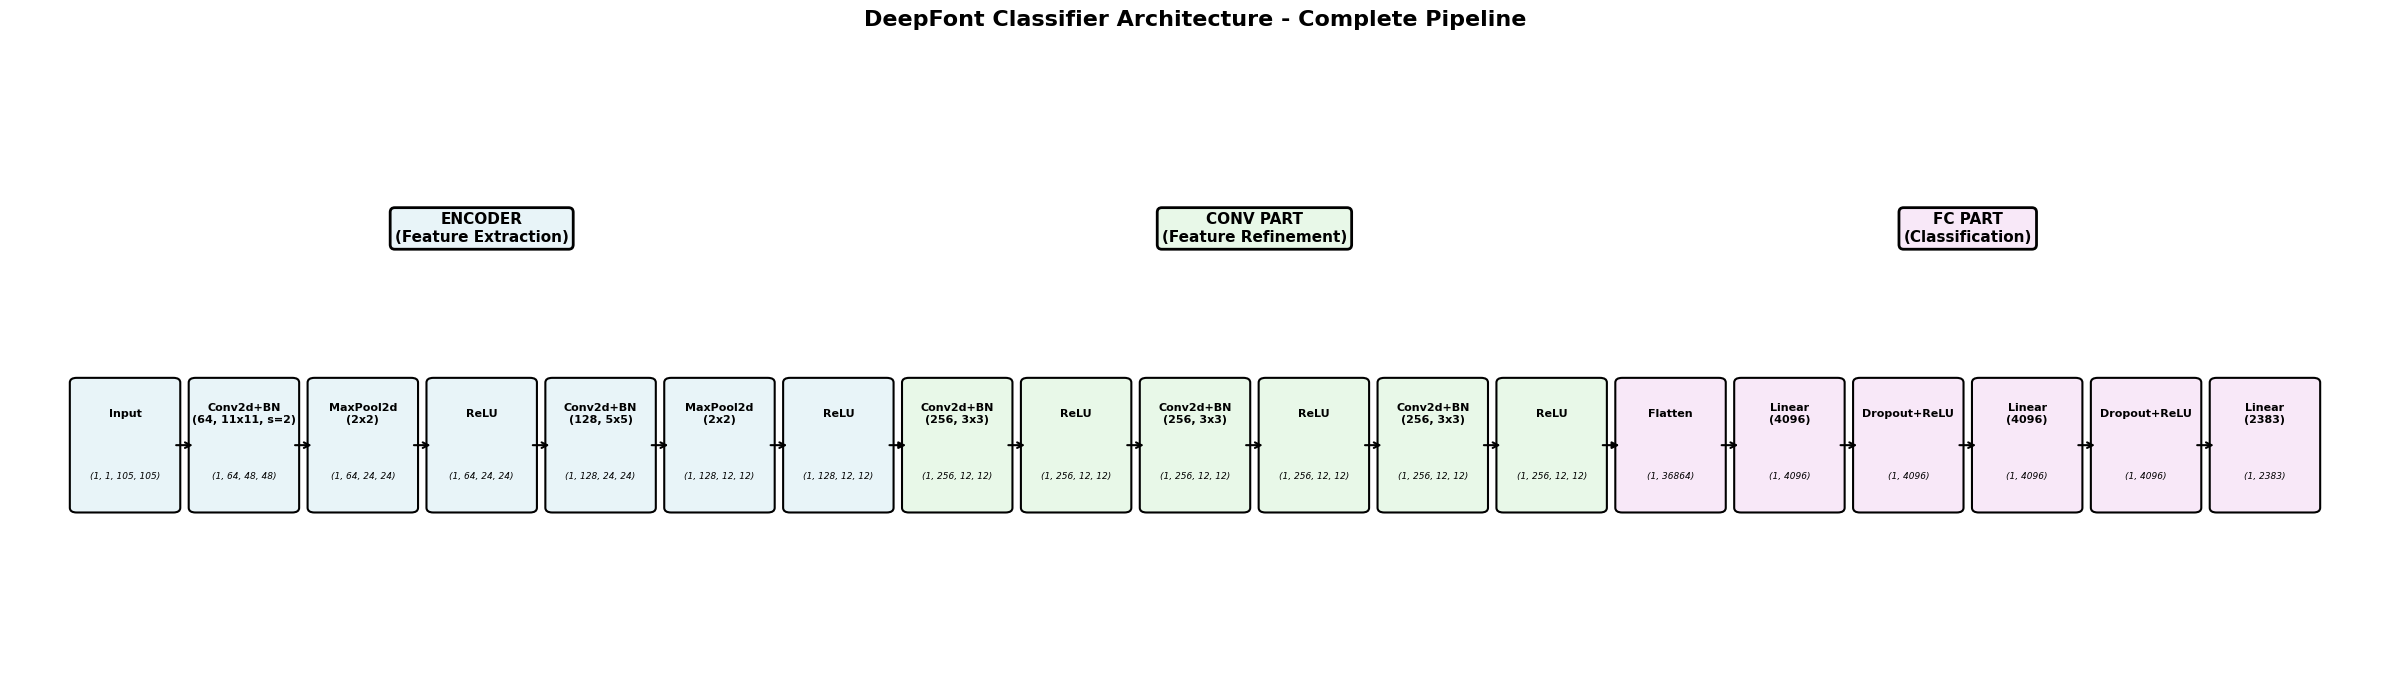

In [8]:
# Create visual diagram of DeepFont classifier architecture
fig, ax = plt.subplots(figsize=(24, 7))
ax.axis("off")

# Define stages with uniform spacing
stage_info = [
    # Encoder
    ("Input", "(1, 1, 105, 105)", "encoder"),
    ("Conv2d+BN\n(64, 11x11, s=2)", "(1, 64, 48, 48)", "encoder"),
    ("MaxPool2d\n(2x2)", "(1, 64, 24, 24)", "encoder"),
    ("ReLU", "(1, 64, 24, 24)", "encoder"),
    ("Conv2d+BN\n(128, 5x5)", "(1, 128, 24, 24)", "encoder"),
    ("MaxPool2d\n(2x2)", "(1, 128, 12, 12)", "encoder"),
    ("ReLU", "(1, 128, 12, 12)", "encoder"),
    # Conv Part
    ("Conv2d+BN\n(256, 3x3)", "(1, 256, 12, 12)", "conv"),
    ("ReLU", "(1, 256, 12, 12)", "conv"),
    ("Conv2d+BN\n(256, 3x3)", "(1, 256, 12, 12)", "conv"),
    ("ReLU", "(1, 256, 12, 12)", "conv"),
    ("Conv2d+BN\n(256, 3x3)", "(1, 256, 12, 12)", "conv"),
    ("ReLU", "(1, 256, 12, 12)", "conv"),
    # FC Part
    ("Flatten", "(1, 36864)", "fc"),
    ("Linear\n(4096)", "(1, 4096)", "fc"),
    ("Dropout+ReLU", "(1, 4096)", "fc"),
    ("Linear\n(4096)", "(1, 4096)", "fc"),
    ("Dropout+ReLU", "(1, 4096)", "fc"),
    ("Linear\n(2383)", "(1, 2383)", "fc"),
]

# Calculate uniform x positions
x_start = 0.05
x_end = 0.98
num_stages = len(stage_info)
x_positions = np.linspace(x_start, x_end, num_stages)

# Combine with positions
stages = [
    (name, shape, x_pos, stage) for (name, shape, stage), x_pos in zip(stage_info, x_positions)
]

# Colors for each stage
stage_colors = {"encoder": "#E8F4F8", "conv": "#E8F8E8", "fc": "#F8E8F8"}

# Draw layers
y_pos = 0.5
box_height = 0.08
box_width = 0.042

for i, (name, shape, x_pos, stage) in enumerate(stages):
    # Draw box
    color = stage_colors[stage]
    box = FancyBboxPatch(
        (x_pos - box_width / 2, y_pos - box_height / 2),
        box_width,
        box_height,
        boxstyle="round,pad=0.003",
        edgecolor="black",
        facecolor=color,
        linewidth=1.5,
    )
    ax.add_patch(box)

    # Add text
    ax.text(x_pos, y_pos + 0.02, name, ha="center", va="center", fontsize=8, fontweight="bold")
    ax.text(x_pos, y_pos - 0.02, shape, ha="center", va="center", fontsize=6.5, style="italic")

    # Draw arrow to next layer
    if i < len(stages) - 1:
        next_x = stages[i + 1][2]
        arrow_style = "->" if stages[i][3] == stages[i + 1][3] else "-|>"
        ax.annotate(
            "",
            xy=(next_x - box_width / 2, y_pos),
            xytext=(x_pos + box_width / 2, y_pos),
            arrowprops=dict(arrowstyle=arrow_style, lw=1.5, color="black"),
        )

# Add stage labels centered above each section, closer to the boxes
# Calculate center positions for each group
encoder_indices = [i for i, (_, _, _, stage) in enumerate(stages) if stage == "encoder"]
conv_indices = [i for i, (_, _, _, stage) in enumerate(stages) if stage == "conv"]
fc_indices = [i for i, (_, _, _, stage) in enumerate(stages) if stage == "fc"]

encoder_center = np.mean([stages[i][2] for i in encoder_indices])
conv_center = np.mean([stages[i][2] for i in conv_indices])
fc_center = np.mean([stages[i][2] for i in fc_indices])

label_y = 0.63  # Closer to boxes

# Add stage labels
ax.text(
    encoder_center,
    label_y,
    "ENCODER\n(Feature Extraction)",
    fontsize=11,
    fontweight="bold",
    ha="center",
    bbox=dict(boxstyle="round", facecolor=stage_colors["encoder"], edgecolor="black", linewidth=2),
)
ax.text(
    conv_center,
    label_y,
    "CONV PART\n(Feature Refinement)",
    fontsize=11,
    fontweight="bold",
    ha="center",
    bbox=dict(boxstyle="round", facecolor=stage_colors["conv"], edgecolor="black", linewidth=2),
)
ax.text(
    fc_center,
    label_y,
    "FC PART\n(Classification)",
    fontsize=11,
    fontweight="bold",
    ha="center",
    bbox=dict(boxstyle="round", facecolor=stage_colors["fc"], edgecolor="black", linewidth=2),
)

ax.set_xlim(0, 1.03)
ax.set_ylim(0.35, 0.75)

plt.title(
    "DeepFont Classifier Architecture - Complete Pipeline", fontsize=16, fontweight="bold", pad=20
)
plt.tight_layout()

# Save the figure
save_path = assets_dir / "deepfont_classifier_architecture.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
print(f"Saved visualization to: {save_path}")

plt.show()

## Step 5: Comparison and Transfer Learning

### 5.1 Encoder Comparison
Compare the encoder architectures between DeepFontAE and DeepFont:
- Highlight similarities (conv layer structure)
- Highlight differences (batch normalization)
- Show parameter mapping for transfer learning

### 5.2 Parameter Statistics
Display comparative statistics:
- Total parameters in each model
- Trainable vs. frozen parameters (when using pretrained encoder)
- Memory requirements

### 5.3 Transfer Learning Visualization
Illustrate the transfer learning workflow:
1. Pretrain DeepFontAE on unlabeled font images
2. Extract encoder weights
3. Load into DeepFont encoder (with layer mapping)
4. Freeze pretrained weights
5. Train classification layers on labeled data

Saved visualization to: ../assets/encoder_comparison.png


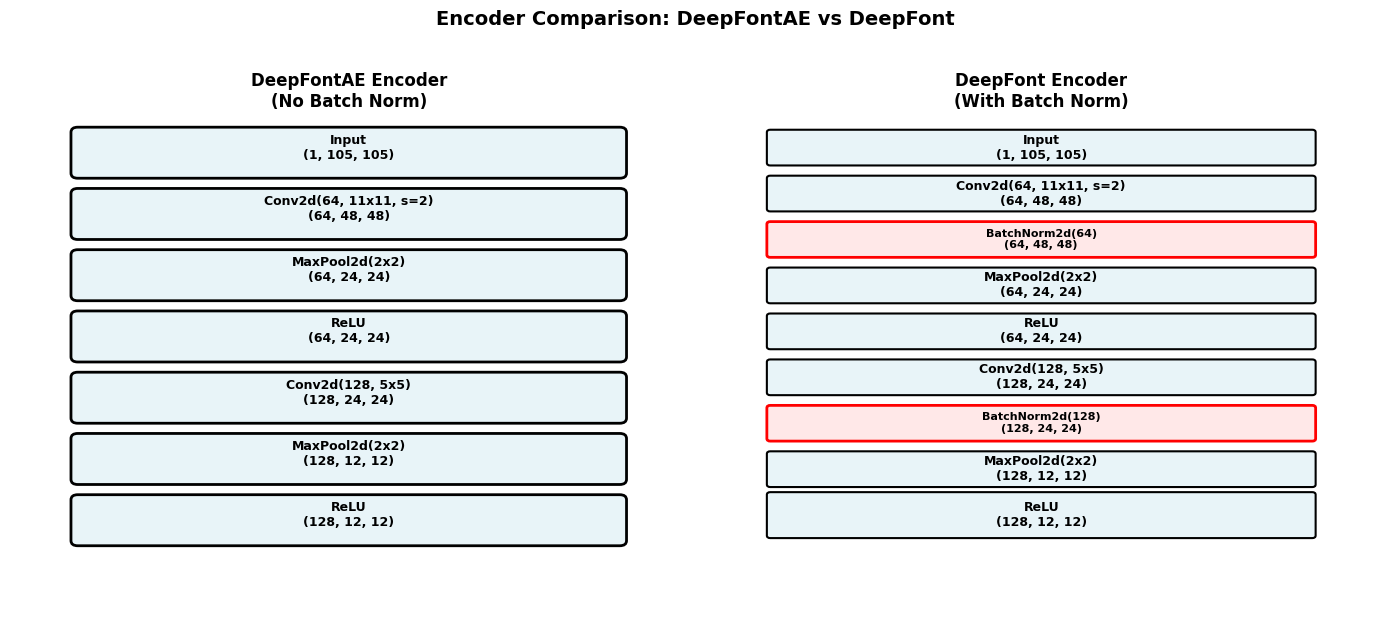

In [9]:
# Compare encoder architectures
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# DeepFontAE Encoder
ax = axes[0]
ax.axis("off")
ae_encoder_info = [
    ("Input", "(1, 105, 105)"),
    ("Conv2d(64, 11x11, s=2)", "(64, 48, 48)"),
    ("MaxPool2d(2x2)", "(64, 24, 24)"),
    ("ReLU", "(64, 24, 24)"),
    ("Conv2d(128, 5x5)", "(128, 24, 24)"),
    ("MaxPool2d(2x2)", "(128, 12, 12)"),
    ("ReLU", "(128, 12, 12)"),
]

y = 0.9
for name, shape in ae_encoder_info:
    has_bn = False
    box_color = "#E8F4F8"
    ax.add_patch(
        FancyBboxPatch(
            (0.1, y - 0.05),
            0.8,
            0.08,
            boxstyle="round,pad=0.01",
            edgecolor="black",
            facecolor=box_color,
            linewidth=2,
        )
    )
    ax.text(0.5, y, f"{name}\n{shape}", ha="center", va="center", fontsize=9, fontweight="bold")
    y -= 0.12

ax.text(
    0.5, 0.98, "DeepFontAE Encoder\n(No Batch Norm)", ha="center", fontsize=12, fontweight="bold"
)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# DeepFont Encoder
ax = axes[1]
ax.axis("off")
df_encoder_info = [
    ("Input", "(1, 105, 105)"),
    ("Conv2d(64, 11x11, s=2)", "(64, 48, 48)"),
    ("BatchNorm2d(64)", "(64, 48, 48)"),
    ("MaxPool2d(2x2)", "(64, 24, 24)"),
    ("ReLU", "(64, 24, 24)"),
    ("Conv2d(128, 5x5)", "(128, 24, 24)"),
    ("BatchNorm2d(128)", "(128, 24, 24)"),
    ("MaxPool2d(2x2)", "(128, 12, 12)"),
    ("ReLU", "(128, 12, 12)"),
]

y = 0.9
for i, (name, shape) in enumerate(df_encoder_info):
    has_bn = "BatchNorm" in name
    box_color = "#FFE8E8" if has_bn else "#E8F4F8"
    height = 0.06 if i < len(df_encoder_info) - 1 else 0.08
    ax.add_patch(
        FancyBboxPatch(
            (0.1, y - height / 2),
            0.8,
            height,
            boxstyle="round,pad=0.005",
            edgecolor="red" if has_bn else "black",
            facecolor=box_color,
            linewidth=2 if has_bn else 1.5,
        )
    )
    ax.text(
        0.5,
        y,
        f"{name}\n{shape}",
        ha="center",
        va="center",
        fontsize=8 if has_bn else 9,
        fontweight="bold",
    )
    y -= 0.09

ax.text(
    0.5, 0.98, "DeepFont Encoder\n(With Batch Norm)", ha="center", fontsize=12, fontweight="bold"
)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.suptitle("Encoder Comparison: DeepFontAE vs DeepFont", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()

# Save the figure
save_path = assets_dir / "encoder_comparison.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
print(f"Saved visualization to: {save_path}")

plt.show()

Parameter Statistics

DeepFontAE:
  Total parameters:     425,345
  Trainable parameters: 425,345
  Memory (float32):     ~1.62 MB

DeepFont Classifier:
  Total parameters:     179,233,487
  Trainable parameters: 179,233,487
  Memory (float32):     ~683.72 MB

Encoder Comparison:
  DeepFontAE encoder:   212,736 parameters
  DeepFont encoder:     213,120 parameters
  Difference (BatchNorm): 384 parameters
Saved visualization to: ../assets/parameter_statistics.png


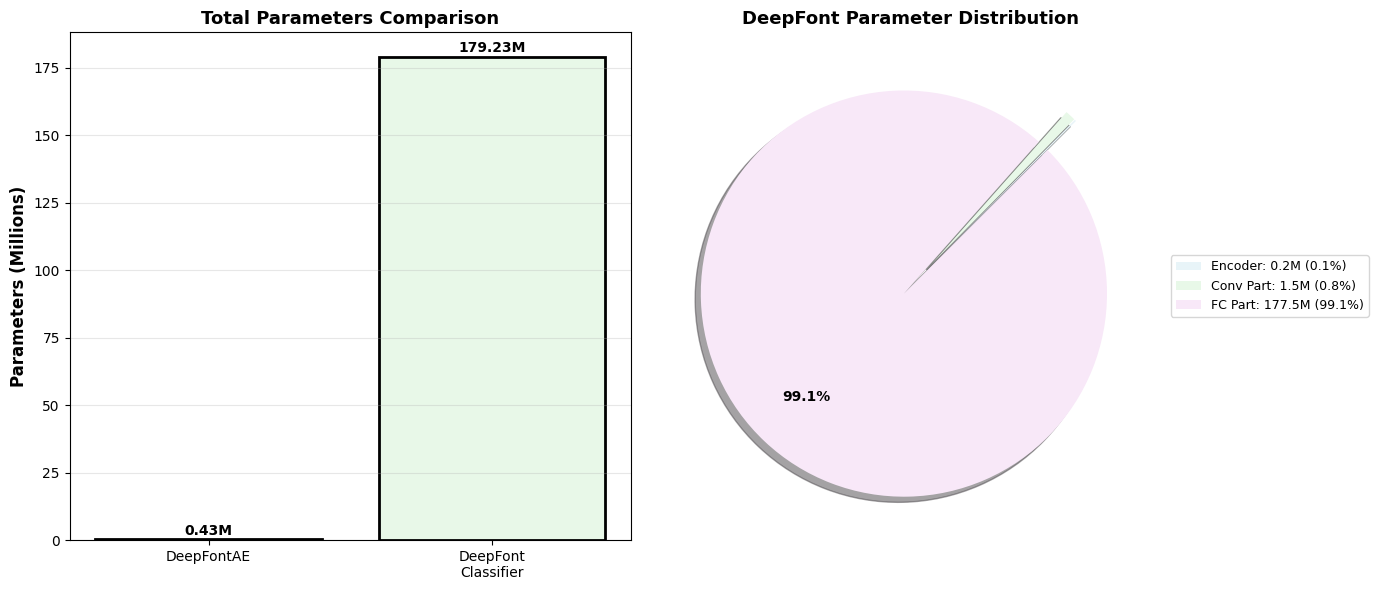

In [10]:
# Display parameter statistics
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable


print("=" * 80)
print("Parameter Statistics")
print("=" * 80)

# DeepFontAE
ae_total, ae_trainable = count_parameters(ae_model)
print(f"\nDeepFontAE:")
print(f"  Total parameters:     {ae_total:,}")
print(f"  Trainable parameters: {ae_trainable:,}")
print(f"  Memory (float32):     ~{ae_total * 4 / 1024 / 1024:.2f} MB")

# DeepFont
df_total, df_trainable = count_parameters(classifier_model)
print(f"\nDeepFont Classifier:")
print(f"  Total parameters:     {df_total:,}")
print(f"  Trainable parameters: {df_trainable:,}")
print(f"  Memory (float32):     ~{df_total * 4 / 1024 / 1024:.2f} MB")

# Encoder comparison
ae_encoder_total = sum(p.numel() for p in ae_model.encoder.parameters())
df_encoder_total = sum(p.numel() for p in classifier_model.encoder.parameters())
print(f"\nEncoder Comparison:")
print(f"  DeepFontAE encoder:   {ae_encoder_total:,} parameters")
print(f"  DeepFont encoder:     {df_encoder_total:,} parameters")
print(f"  Difference (BatchNorm): {df_encoder_total - ae_encoder_total:,} parameters")

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart of total parameters
models = ["DeepFontAE", "DeepFont\nClassifier"]
totals = [ae_total / 1e6, df_total / 1e6]  # Convert to millions
colors = ["#E8F4F8", "#E8F8E8"]

ax1.bar(models, totals, color=colors, edgecolor="black", linewidth=2)
ax1.set_ylabel("Parameters (Millions)", fontsize=12, fontweight="bold")
ax1.set_title("Total Parameters Comparison", fontsize=13, fontweight="bold")
ax1.grid(axis="y", alpha=0.3)
for i, v in enumerate(totals):
    ax1.text(i, v + 0.5, f"{v:.2f}M", ha="center", va="bottom", fontweight="bold")

# Pie chart for DeepFont breakdown
df_encoder_params = df_encoder_total
df_conv_params = sum(p.numel() for p in classifier_model.conv_part.parameters())
df_fc_params = sum(p.numel() for p in classifier_model.fc_part.parameters())

labels = ["Encoder", "Conv Part", "FC Part"]
sizes = [df_encoder_params, df_conv_params, df_fc_params]
colors_pie = ["#E8F4F8", "#E8F8E8", "#F8E8F8"]
explode = (0.15, 0.15, 0.05)

# Only show percentages on the pie chart
wedges, texts, autotexts = ax2.pie(
    sizes,
    explode=explode,
    labels=None,  # Don't show labels on pie
    colors=colors_pie,
    autopct=lambda pct: f"{pct:.1f}%" if pct > 2 else "",
    shadow=True,
    startangle=45,
    textprops={"fontsize": 10, "fontweight": "bold"},
    pctdistance=0.7,
)

# Add legend with full information
legend_labels = [
    f"{labels[i]}: {sizes[i] / 1e6:.1f}M ({sizes[i] / sum(sizes) * 100:.1f}%)"
    for i in range(len(labels))
]
ax2.legend(
    wedges,
    legend_labels,
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=9,
)

ax2.set_title("DeepFont Parameter Distribution", fontsize=13, fontweight="bold")

plt.tight_layout()

# Save the figure
save_path = assets_dir / "parameter_statistics.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
print(f"Saved visualization to: {save_path}")

plt.show()

Saved visualization to: ../assets/transfer_learning_workflow.png


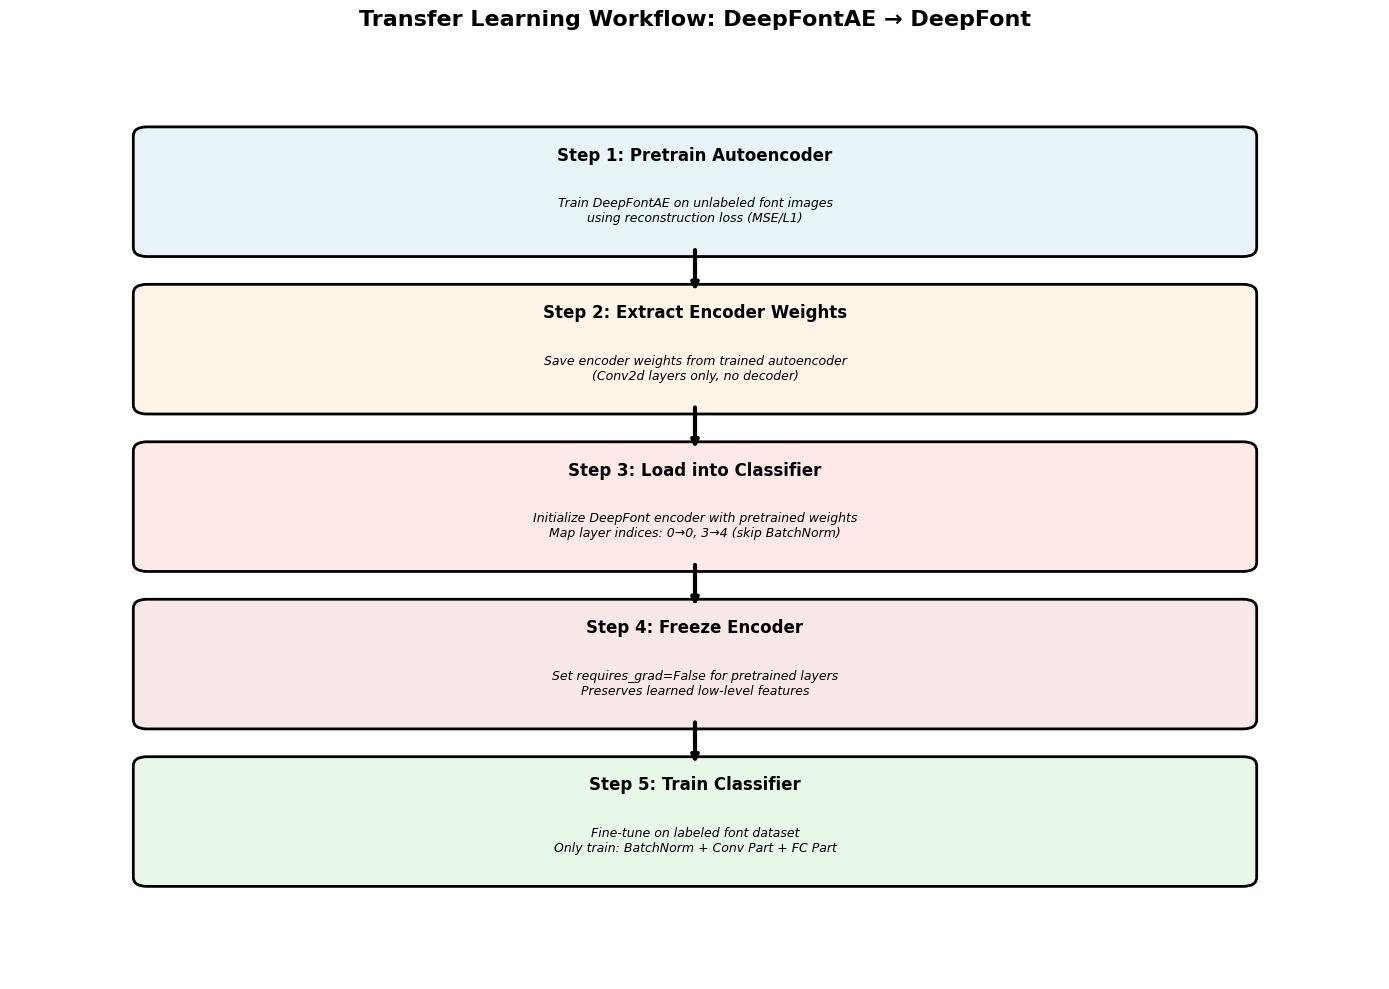

In [11]:
# Visualize transfer learning workflow
fig, ax = plt.subplots(figsize=(14, 10))
ax.axis("off")

# Define workflow steps
steps = [
    {
        "title": "Step 1: Pretrain Autoencoder",
        "desc": "Train DeepFontAE on unlabeled font images\nusing reconstruction loss (MSE/L1)",
        "y": 0.85,
        "color": "#E8F4F8",
    },
    {
        "title": "Step 2: Extract Encoder Weights",
        "desc": "Save encoder weights from trained autoencoder\n(Conv2d layers only, no decoder)",
        "y": 0.68,
        "color": "#FFF4E8",
    },
    {
        "title": "Step 3: Load into Classifier",
        "desc": "Initialize DeepFont encoder with pretrained weights\nMap layer indices: 0→0, 3→4 (skip BatchNorm)",
        "y": 0.51,
        "color": "#FFE8E8",
    },
    {
        "title": "Step 4: Freeze Encoder",
        "desc": "Set requires_grad=False for pretrained layers\nPreserves learned low-level features",
        "y": 0.34,
        "color": "#F8E8E8",
    },
    {
        "title": "Step 5: Train Classifier",
        "desc": "Fine-tune on labeled font dataset\nOnly train: BatchNorm + Conv Part + FC Part",
        "y": 0.17,
        "color": "#E8F8E8",
    },
]

# Draw workflow boxes
for i, step in enumerate(steps):
    # Main box
    box = FancyBboxPatch(
        (0.1, step["y"] - 0.06),
        0.8,
        0.12,
        boxstyle="round,pad=0.01",
        edgecolor="black",
        facecolor=step["color"],
        linewidth=2,
    )
    ax.add_patch(box)

    # Title
    ax.text(
        0.5,
        step["y"] + 0.04,
        step["title"],
        ha="center",
        va="center",
        fontsize=12,
        fontweight="bold",
    )

    # Description
    ax.text(
        0.5, step["y"] - 0.02, step["desc"], ha="center", va="center", fontsize=9, style="italic"
    )

    # Arrow to next step
    if i < len(steps) - 1:
        ax.annotate(
            "",
            xy=(0.5, steps[i + 1]["y"] + 0.06),
            xytext=(0.5, step["y"] - 0.06),
            arrowprops=dict(arrowstyle="->", lw=3, color="black"),
        )

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.title(
    "Transfer Learning Workflow: DeepFontAE → DeepFont", fontsize=16, fontweight="bold", pad=20
)
plt.tight_layout()

# Save the figure
save_path = assets_dir / "transfer_learning_workflow.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
print(f"Saved visualization to: {save_path}")

plt.show()

## Step 6: Computational Graph Visualization (Optional)

If `torchviz` is available, create computational graph visualizations:
- Forward pass graph for DeepFontAE
- Forward pass graph for DeepFont
- Show gradient flow and connections between layers

This provides a different perspective on the model architecture, focusing on the computational operations rather than just layer structure.

In [12]:
# Optional: Try to create computational graph visualization
try:
    from torchviz import make_dot

    # Create a sample input (ensure correct device)
    device = next(ae_model.parameters()).device
    sample_input = torch.randn(1, 1, 105, 105, device=device, requires_grad=True)

    # Generate computational graph for DeepFontAE
    print("Generating computational graph for DeepFontAE...")
    ae_output = ae_model(sample_input)
    ae_graph = make_dot(
        ae_output, params=dict(ae_model.named_parameters()), show_attrs=False, show_saved=False
    )
    ae_graph_path = assets_dir / "deepfontae_graph"
    ae_graph.render(ae_graph_path, format="png", cleanup=True)
    print(f"Saved DeepFontAE computational graph to: {ae_graph_path}.png")

    # Generate computational graph for DeepFont
    print("Generating computational graph for DeepFont...")
    sample_input2 = torch.randn(1, 1, 105, 105, device=device, requires_grad=True)
    clf_output = classifier_model(sample_input2)
    clf_graph = make_dot(
        clf_output,
        params=dict(classifier_model.named_parameters()),
        show_attrs=False,
        show_saved=False,
    )
    clf_graph_path = assets_dir / "deepfont_classifier_graph"
    clf_graph.render(clf_graph_path, format="png", cleanup=True)
    print(f"Saved DeepFont computational graph to: {clf_graph_path}.png")

    print("Computational graphs created successfully!")
    print("Note: These graphs show the forward pass operations and parameter dependencies.")

except ImportError:
    print("torchviz not available. Skipping computational graph visualization.")
    print("  To enable: pip install torchviz graphviz")
except Exception as e:
    print(f"Could not create computational graphs: {e}")
    print("  This is optional and doesn't affect the main visualizations.")

Generating computational graph for DeepFontAE...
Saved DeepFontAE computational graph to: ../assets/deepfontae_graph.png
Generating computational graph for DeepFont...
Saved DeepFont computational graph to: ../assets/deepfont_classifier_graph.png
Computational graphs created successfully!
Note: These graphs show the forward pass operations and parameter dependencies.
